In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("data/names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:10])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(list(set(''.join(words))))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i:s for s,i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
# dataset
block_size = 3 # context length
def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = s_to_i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1]) # 0.8
Xdev, Ydev = build_dataset(words[n1:n2]) # 0.1
Xte,  Yte  = build_dataset(words[n2:]) # 0.1

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
Xtr[:3][1][2].item()

25

In [7]:
Xtr[:3]

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21]])

In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(i_to_s[ix.item()] for ix in x), '-->', i_to_s[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [25]:
class Linear:
  __slots__ = "weights", "bias", "out"
  
  def __init__(self, n_in, n_out, bias=True):
    self.weights = torch.randn((n_in, n_out)) / n_in**0.5 # kaiming init
    self.bias = torch.zeros(n_out) if bias else None
    
  def __call__(self, x):
    self.out = x @ self.weights
    if self.bias is not None:
      self.out += self.bias # in what exact way does it fail when it's + insted of +=
    return self.out
  
  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  __slots__ = "eps", "momentum", "training", "gamma", "beta", "running_mean", "running_var", "out"
    
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # param
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    
  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    xhat = (x - xmean) / (xvar - self.eps) # norm to unit variance
    self.out = self.gamma * xhat + self.beta
    
    if self.training:
      with torch.no_grad():
        #print("once?")
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
    
    
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []
  
  
class Embedding:
  __slots__ = "weights", "out"

  def __init__(self, num_embds, embd_dim):
    self.weights = torch.randn((num_embds, embd_dim))
    
  def __call__(self, Ix):
    self.out = self.weights[Ix]
    return self.out
  
  def parameters(self):
    return [self.weights]
  
class Flatten:
  __slots__ = "out"

  def __call__(self, X: 'Tensor'):
    self.out = X.view(X.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
class Sequential:
  __slots__ = "layers", "out"

  def __init__(self, layers: list):
    self.layers = layers
    
  def __call__(self, x: 'Tensor'):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42);

In [26]:
n_embd = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weights *= 0.1

parameters = model.parameters()

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [32]:
#max_steps = 200_000
max_steps = 10_000
batch_size = 32
lossi = []

for layer in model.layers:
    if hasattr(layer, 'training'):
        layer.training = True

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  for p in parameters:
    p.grad = None

  loss.backward()
  
  lr = 0.1 if i < 150_000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  #if i % 10_000 == 0:
  if i % 4_000 == 0:
    print(f"{i:7d} / {max_steps:7d} - {loss.item():.4f}")
  lossi.append(loss.log10().item())

loss.item()

      0 /   10000 - 2.1619
   4000 /   10000 - 2.4826
   8000 /   10000 - 2.3534


2.207428455352783

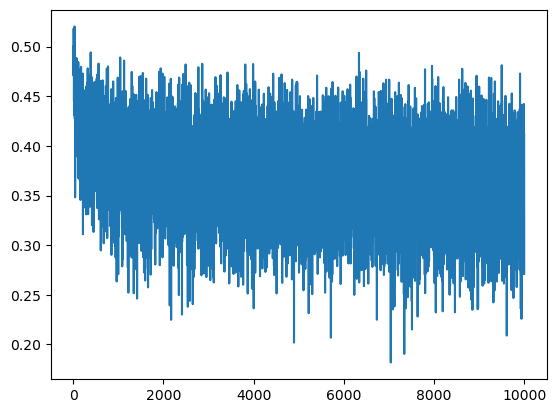

In [29]:
plt.plot(lossi)

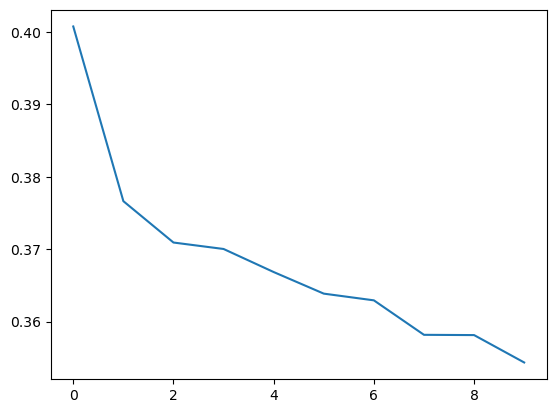

In [30]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [33]:
for layer in model.layers:
    if hasattr(layer, 'training'):
        layer.training = False

In [34]:
for layer in model.layers:
    if hasattr(layer, 'training'):
        print(layer.training)

False


In [35]:
# eval
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'teset': (Xte, Yte)
  }[split]
  
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  
  print(split, loss.item())
  
split_loss('train')
split_loss('val')

train 2.2387542724609375
val 2.2577435970306396


In [36]:
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    
    ix = torch.multinomial(probs, num_samples=1).item()
    
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
    
  print("".join(i_to_s[ch] for ch in out))

natte.
matah.
ruzaileighapevlenya.
kassincie.
syn.
han.
quina.
lizgerick.
jroth.
enarielianiyanayaren.
rholin.
bran.
ana.
sevie.
kylen.
bsen.
fingelians.
rathika.
matas.
raylina.
